Ahilan Kumaresan

In [4]:
import numpy as np
import matplotlib.pyplot as plt

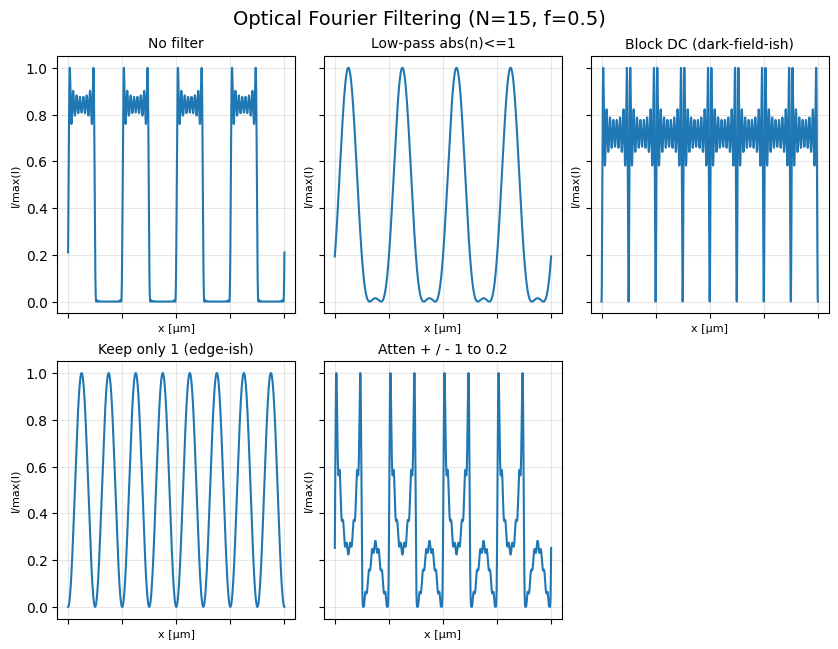

In [15]:
def ronchi_coeffs(N, duty_cycle):

    f = duty_cycle
    n = np.arange(-N, N+1, dtype=int)

    c = np.zeros_like(n, dtype=complex)

    # n=0
    c[n == 0] = f

    # n != 0
    nz = (n != 0)
    nn = n[nz].astype(float)
    c[nz] = (np.sin(np.pi * nn * f) / (np.pi * nn)) * np.exp(-1j * np.pi * nn * f)

    return n, c

def make_mask(n, mode="", **kwargs):

    M = np.ones_like(n, dtype=complex)

    if mode == "":
        return M

    if mode == "block_dc":
        M[n == 0] = 0
        return M

    if mode == "keep_orders":

        keep = set(kwargs.get("keep", []))
        M[:] = 0
        for k in keep:
            M[n == k] = 1
        return M

    if mode == "lowpass":
        nmax = int(kwargs.get("nmax", 1))
        M[np.abs(n) > nmax] = 0
        return M

    if mode == "attenuate":
        scale = kwargs.get("scale", {})
        for k, s in scale.items():
            M[n == int(k)] *= complex(s)
        return M

    if mode == "phase_shift":
        
        phase = kwargs.get("phase", {})
        for k, ph in phase.items():
            M[n == int(k)] *= np.exp(1j * float(ph))
        return M

    raise ValueError(f"Unknown mode: {mode}")

def field_and_intensity(d, duty_cycle, N, x, mask=None):
    n, c = ronchi_coeffs(N, duty_cycle)

    if mask is None:
        M = np.ones_like(c, dtype=complex)
    else:
        M = mask

    # Build exp(i 2π n x/d) efficiently: shape (num_orders, num_x)
    phase = np.exp(1j * 2*np.pi * np.outer(n, x) / d)
    E = np.sum((c * M)[:, None] * phase, axis=0)
    I = np.abs(E)**2
    return n, c, M, E, I

def normalize(I):
    return I / np.max(I)

# PARAMETERS 
d = 100e-6  # period [m]  (example: 10 lp/mm => d=0.1 mm = 100 µm)
f = 0.50      # duty cycle (open fraction); use your measured/assumed value
N = 15   # truncation order
x = np.linspace(-2*d, 2*d, 4000)  # evaluate over several periods

# EXAMPLE
cases = [
    ("No filter",                 make_mask(np.arange(-N, N+1), mode="")),
    ("Low-pass abs(n)<=1",          make_mask(np.arange(-N, N+1), mode="lowpass", nmax=1)),
    ("Block DC (dark-field-ish)",make_mask(np.arange(-N, N+1), mode="block_dc")),
    ("Keep only 1 (edge-ish)",  make_mask(np.arange(-N, N+1), mode="keep_orders", keep=[-1, 1])),
    ("Atten + / - 1 to 0.2",          make_mask(np.arange(-N, N+1), mode="attenuate", scale={-1:0.2, 1:0.2})),
]


A4_WIDTH = 8.27
A4_HEIGHT = 11.69

fig, axs = plt.subplots(4, 3, figsize=(A4_WIDTH, A4_HEIGHT), 
                        layout='constrained', sharex=True, sharey=True)

for (label, M), ax in zip(cases, axs.flat):
    n, c, M, E, I = field_and_intensity(d=d, duty_cycle=f, N=N, x=x, mask=M)
    
    ax.plot(x*1e6, normalize(I))
    

    ax.set_title(label, fontsize=10)
    ax.set_xlabel("x [µm]", fontsize=8)
    ax.set_ylabel("I/max(I)", fontsize=8)
    ax.grid(True, alpha=0.3)

for ax in axs.flat[len(cases):]:
    ax.set_visible(False) # Hiding other non printing plots

fig.suptitle(f"Optical Fourier Filtering (N={N}, f={f})", fontsize=14)

plt.show()